In [17]:
import torch
print(torch.__version__)

2.2.1+cpu


In [18]:
import json
import collections
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
import matplotlib.animation as animation
import itertools
from itertools import combinations

import math

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch_geometric.data import Data
from torch_geometric.data import DataLoader as DataLoaderGraph
from torch_geometric.data import Dataset as DatasetGraph
from torch_geometric.data import Batch as BatchGraph
from torch_geometric.transforms import RandomNodeSplit as masking

from torch_geometric.nn import GCNConv, BatchNorm, SAGEConv, SGConv, ChebConv
from torch_geometric.utils.convert import to_networkx

import networkx as nx


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx

In [21]:
print(torch_geometric.__version__)

2.5.3


In [22]:
with open("data/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)
edges=pd.read_csv("data/musae_git_edges.csv")
target_df=pd.read_csv("data/musae_git_target.csv")

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [23]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


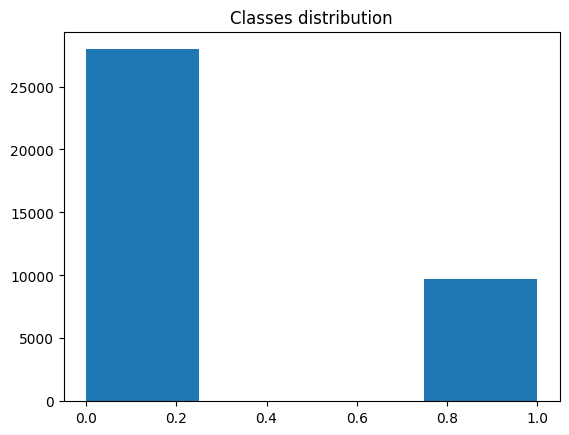

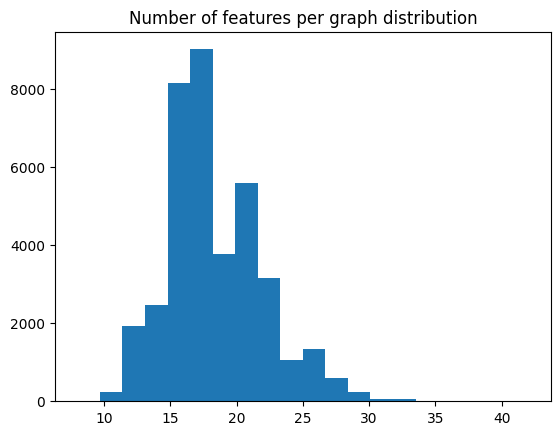

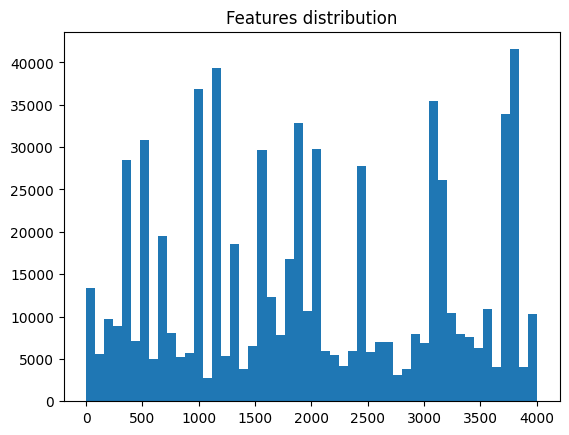

In [24]:
plt.hist(target_df.ml_target,bins=4);
plt.title("Classes distribution")
plt.show()

plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()

plt.hist(feats,bins=50)
plt.title("Features distribution")
plt.show()

In [25]:
counter=collections.Counter(feats)
print(list(counter.keys())[:10])
print(list(counter.values())[:10])
print(list(counter.keys())[-10:])
print(list(counter.values())[-10:])

[1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045]
[5045, 12726, 2486, 298, 165, 510, 22075, 28188, 24958, 21449]
[936, 172, 875, 3548, 2745, 793, 1941, 464, 2616, 3124]
[1, 2, 1, 2, 1, 1, 1, 1, 1, 1]


In [35]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

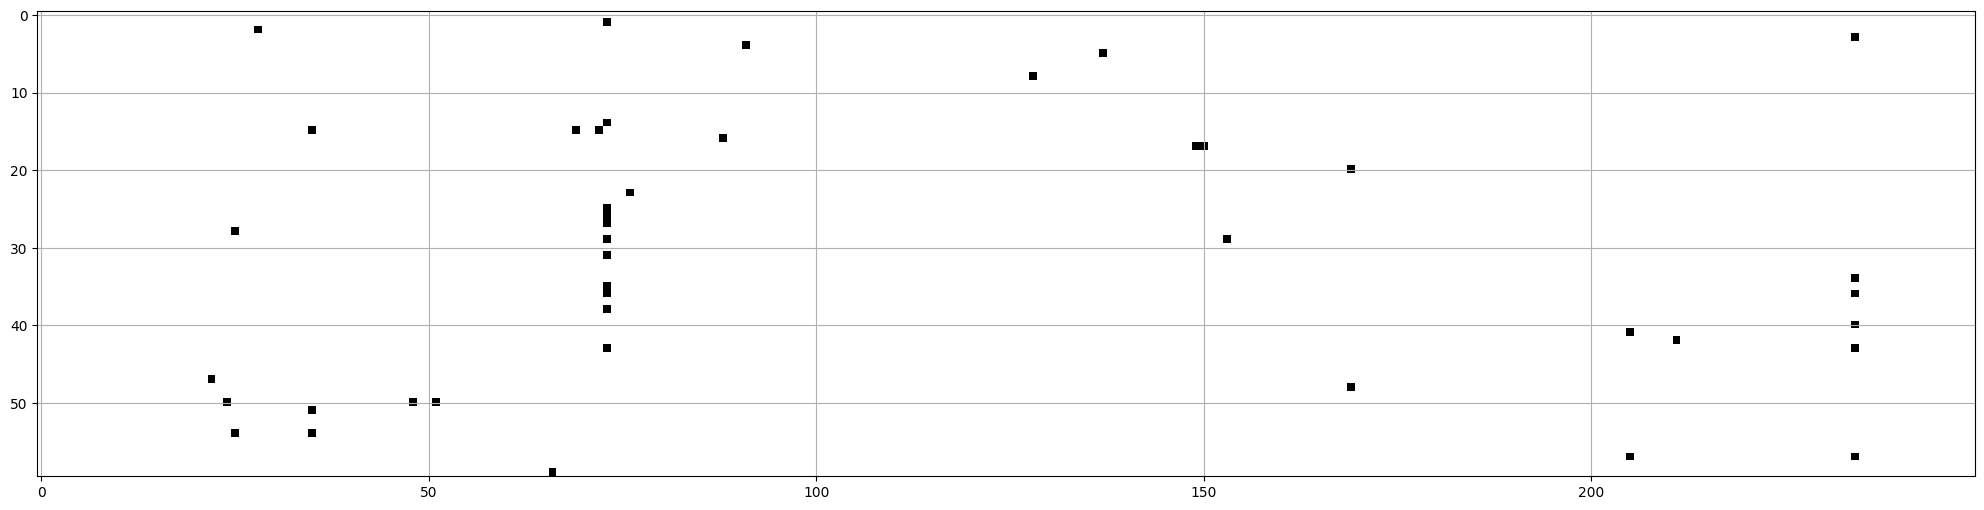

In [36]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');
plt.grid()

In [37]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [38]:
#g_top_draw = Data(x=node_features, y=node_labels, edge_index=edge_index0)

def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
        
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

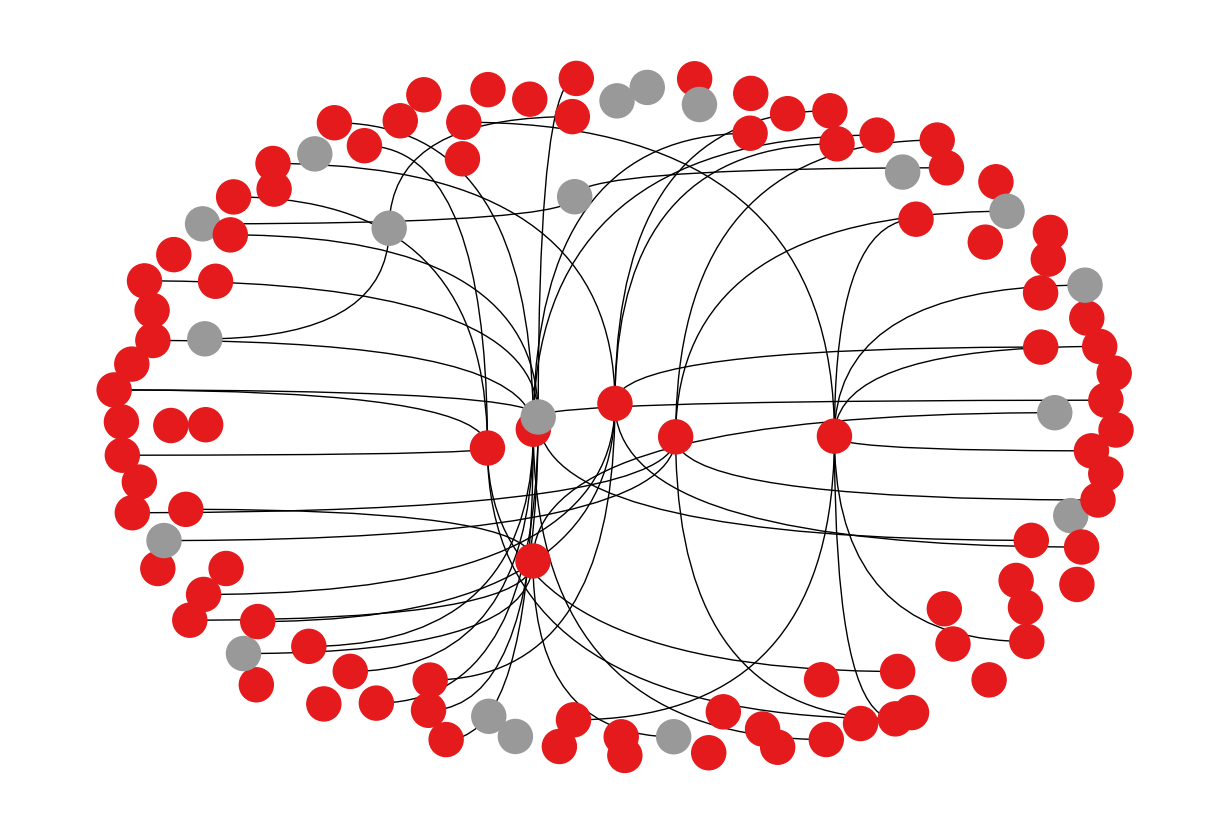

In [41]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)

In [42]:
data_encoded,_=encode_data(light=False)
g=construct_graph(data_encoded=data_encoded,light=False)
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

training samples 3770
validation samples 11310
test samples 22620


In [43]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()


        self.conv1 = GCNConv(num_of_feat, f)

        self.conv2 = GCNConv(f, 2)


    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
          
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        return x

In [44]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)   

In [45]:
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy) 

In [53]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    
    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]

    for ep in range(epochs+1):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss]
        
        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]

        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy

    
    plt.plot(train_accuracies) 
    plt.plot(val_accuracies)
    plt.plot(test_accuracies) 
    plt.show()



Epoch 1/50, Train_Loss: 0.6913, Train_Accuracy: 0.6660, Val_Accuracy: 0.6664, Test_Accuracy: 0.6687
Epoch 2/50, Train_Loss: 0.7398, Train_Accuracy: 0.7432, Val_Accuracy: 0.7378, Test_Accuracy: 0.7433
Epoch 4/50, Train_Loss: 0.5312, Train_Accuracy: 0.7438, Val_Accuracy: 0.7382, Test_Accuracy: 0.7436
Epoch 5/50, Train_Loss: 0.5221, Train_Accuracy: 0.7446, Val_Accuracy: 0.7385, Test_Accuracy: 0.7441
Epoch 6/50, Train_Loss: 0.4814, Train_Accuracy: 0.7446, Val_Accuracy: 0.7388, Test_Accuracy: 0.7446
Epoch 7/50, Train_Loss: 0.4507, Train_Accuracy: 0.7451, Val_Accuracy: 0.7393, Test_Accuracy: 0.7451
Epoch 8/50, Train_Loss: 0.4466, Train_Accuracy: 0.7491, Val_Accuracy: 0.7433, Test_Accuracy: 0.7486
Epoch 9/50, Train_Loss: 0.4436, Train_Accuracy: 0.7629, Val_Accuracy: 0.7573, Test_Accuracy: 0.7626
Epoch 10/50, Train_Loss: 0.4105, Train_Accuracy: 0.8082, Val_Accuracy: 0.7973, Test_Accuracy: 0.8026
Epoch 11/50, Train_Loss: 0.3597, Train_Accuracy: 0.8507, Val_Accuracy: 0.8439, Test_Accuracy: 0.847

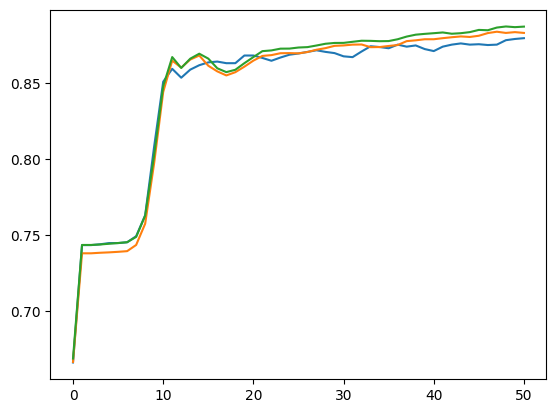

In [54]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=50,lr=0.1)